## **DATA MODELING**

#### **Đề tài**: *Hệ thống dự đoán giá trị chuyển nhượng cầu thủ bóng đá*

#### **Vấn đề quan tâm**: *Phân tích các yếu tố ảnh hưởng đến giá trị chuyển nhượng cầu thủ bóng đá và xây dựng mô hình dự đoán giá trị thị trường dựa trên đặc điểm và thành tích thi đấu.*

### **I. Import các thư viện**

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import joblib
import pickle

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer

# Random Forest
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

# Thiết lập style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


### **II. Đọc và khám phá dữ liệu**

In [125]:
df = pd.read_csv('football_players_dataset.csv')

print("DATASET OVERVIEW")

print(f"\nShape: {df.shape}")
print(f"   - Samples: {df.shape[0]:,}")
print(f"   - Features: {df.shape[1]}")

print("\nColumn Types:")
print(df.dtypes.value_counts())

print("\nFirst 5 rows:")
print(df.head())

# Missing values
missing = df.isnull().sum()
if missing.sum() > 0:
    print(f"\nMissing values found: {missing[missing > 0].sum()} total")
    print("\nColumns with missing values:")
    print(missing[missing > 0])
else:
    print("\nNo missing values!")

DATASET OVERVIEW

Shape: (16453, 46)
   - Samples: 16,453
   - Features: 46

Column Types:
float64    33
int64       8
object      5
Name: count, dtype: int64

First 5 rows:
    age  nationality position position_category current_club        league  \
0  23.0  New Zealand       GK                GK  Auckland FC  A-League Men   
1  27.0      Uruguay       FW                FW  Auckland FC  A-League Men   
2  31.0  New Zealand       DF                DF  Auckland FC  A-League Men   
3  26.0  New Zealand       DF                DF  Auckland FC  A-League Men   
4  35.0        Japan    DF-MF                DF  Auckland FC  A-League Men   

   appearances  minutes_played  is_GK  is_DF  ...  passes_received_per90  \
0           26            2340      1      0  ...                  0.000   
1           26            2268      0      0  ...                 28.280   
2           26            2198      0      1  ...                 34.055   
3           25            2142      0      1  ...    

### **III. Phân tích biến mục tiêu - Market Value**

TARGET VARIABLE: MARKET_VALUE

Distribution Metrics:
   - Mean:     €3.33M
   - Median:   €0.60M
   - Std Dev:  €9.66M
   - Skewness: 7.4679
   - Kurtosis: 82.2152
   - Range:    €0.01M - €200.00M

Saved: RF_01_target_distribution.png


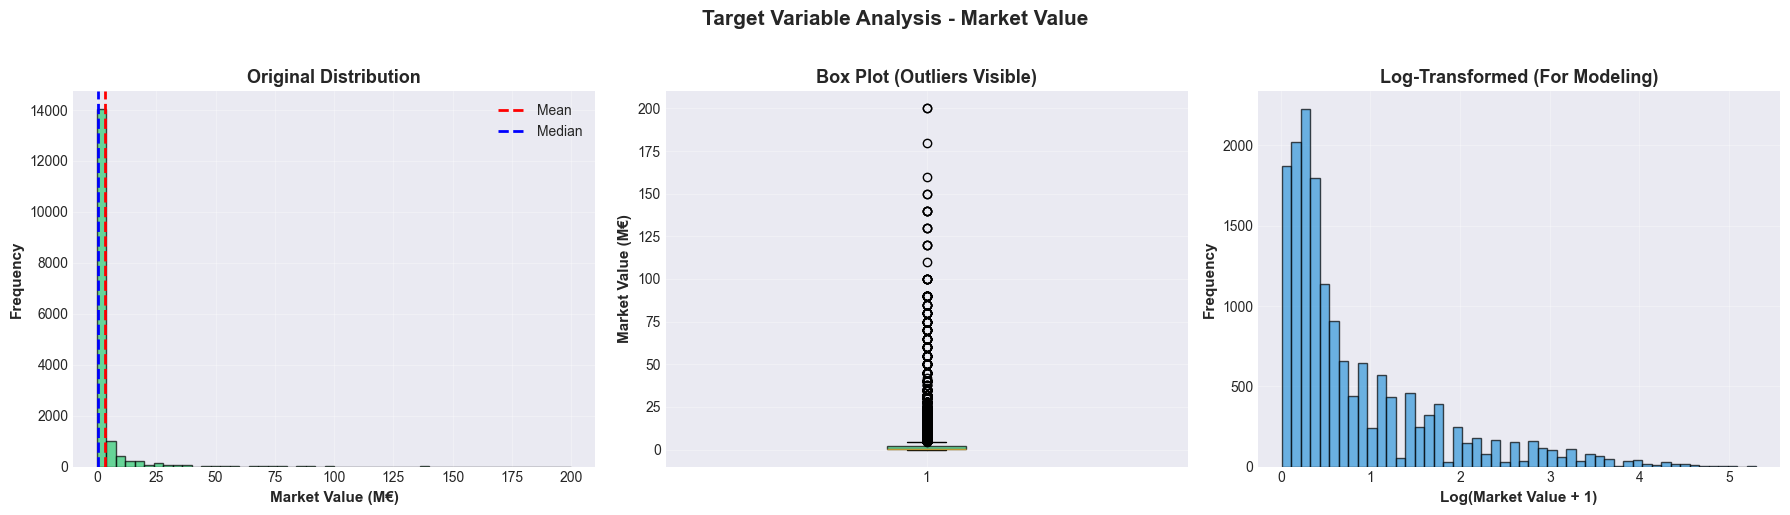

In [126]:
print("TARGET VARIABLE: MARKET_VALUE")

print(f"\nDistribution Metrics:")
print(f"   - Mean:     €{df['market_value'].mean():.2f}M")
print(f"   - Median:   €{df['market_value'].median():.2f}M")
print(f"   - Std Dev:  €{df['market_value'].std():.2f}M")
print(f"   - Skewness: {df['market_value'].skew():.4f}")
print(f"   - Kurtosis: {df['market_value'].kurtosis():.4f}")
print(f"   - Range:    €{df['market_value'].min():.2f}M - €{df['market_value'].max():.2f}M")

# Visualize target distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original distribution
axes[0].hist(df['market_value'], bins=50, edgecolor='black', alpha=0.7, color='#2ecc71')
axes[0].axvline(df['market_value'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0].axvline(df['market_value'].median(), color='blue', linestyle='--', linewidth=2, label='Median')
axes[0].set_xlabel('Market Value (M€)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0].set_title('Original Distribution', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
bp = axes[1].boxplot(df['market_value'], vert=True, patch_artist=True)
bp['boxes'][0].set_facecolor('#2ecc71')
bp['boxes'][0].set_alpha(0.7)
axes[1].set_ylabel('Market Value (M€)', fontsize=11, fontweight='bold')
axes[1].set_title('Box Plot (Outliers Visible)', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)

# Log-transformed
log_values = np.log1p(df['market_value'])
axes[2].hist(log_values, bins=50, edgecolor='black', alpha=0.7, color='#3498db')
axes[2].set_xlabel('Log(Market Value + 1)', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[2].set_title('Log-Transformed (For Modeling)', fontsize=13, fontweight='bold')
axes[2].grid(alpha=0.3)

plt.suptitle('Target Variable Analysis - Market Value', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('RF_01_target_distribution.png', dpi=300, bbox_inches='tight')
print("\nSaved: RF_01_target_distribution.png")
plt.show()

**Nhận xét**: Biến mục tiêu **MARKET_VALUE** có phân phối lệch phải rất mạnh, thể hiện qua sự chênh lệch lớn giữa giá trị trung bình **(3.33 triệu Euro)** và trung vị **(0.60 triệu Euro)**. Độ lệch chuẩn cao cùng khoảng giá trị rộng cho thấy sự phân tán lớn giữa các cầu thủ phổ thông và cầu thủ ngôi sao. **Hệ số lệch (Skewness)** và **độ nhọn (Kurtosis)** lớn chỉ ra sự tồn tại của nhiều giá trị ngoại lai, đặc biệt ở nhóm cầu thủ có giá trị cao.

### **IV. Feature Engineering**

In [127]:
# Copy dữ liệu
df_features = df.copy()
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

#### **1. Biến đổi logarit (Log transformation) cho các đặc trưng có phân phối lệch**

In [128]:
skewed_features = []

for col in numeric_cols:
    if col not in ['market_value', 'is_GK', 'is_DF', 'is_MF', 'is_FW']:
        skewness = abs(df_features[col].skew())
        if skewness > 1.0:
            df_features[f'{col}_log'] = np.log1p(df_features[col])
            skewed_features.append(col)

#### **2. Đặc trưng tỷ lệ (Ratio Feature) - Quan trọng với mô hình Random Forest**

In [129]:
if 'goals' in df_features.columns and 'shots_per90' in df_features.columns:
    df_features['goals_per_shot'] = df_features['goals'] / df_features['shots_per90'].replace(0, 0.01)
    print("DONE: goals_per_shot")

if 'passes_completed_per90' in df_features.columns and 'pass_completion_pct' in df_features.columns:
    df_features['pass_efficiency'] = df_features['passes_completed_per90'] * df_features['pass_completion_pct'] / 100
    print("DONE: pass_efficiency")

if all(col in df_features.columns for col in ['interceptions_per90', 'blocks_per90']):
    df_features['defensive_contribution'] = df_features['interceptions_per90'] + df_features['blocks_per90']
    print("DONE: defensive_contribution")

if all(col in df_features.columns for col in ['progressive_passes_per90', 'progressive_carries_per90']):
    df_features['total_progressive'] = df_features['progressive_passes_per90'] + df_features['progressive_carries_per90']
    print("DONE: total_progressive")

DONE: goals_per_shot
DONE: pass_efficiency
DONE: defensive_contribution
DONE: total_progressive


#### **3. Đặc trưng tương tác (Interaction features)**

In [130]:
df_features['age_experience'] = df_features['age'] * np.log1p(df_features['minutes_played'])
print("DONE: age_experience")

if 'minutes_played' in df_features.columns and 'appearances' in df_features.columns:
    df_features['minutes_per_game'] = df_features['minutes_played'] / df_features['appearances'].replace(0, 1)
    print("DONE: minutes_per_game")

DONE: age_experience
DONE: minutes_per_game


#### **4. Đặc trưng đa thức (Polynomial features)**

In [131]:
key_features = ['goals', 'assists', 'minutes_played']

for feat in key_features:
    if feat in df_features.columns:
        df_features[f'{feat}_squared'] = df_features[feat] ** 2
        print(f"DONE: {feat}_squared")

DONE: goals_squared
DONE: assists_squared
DONE: minutes_played_squared


#### **5. Mã hóa các biến phân loại (Encoding categorical variables)**

In [132]:
categorical_cols = ['nationality', 'position', 'current_club', 'league']

# 1. FREQUENCY ENCODING 
for col in categorical_cols:
    if col in df_features.columns:
        freq = df_features[col].value_counts()
        df_features[f'{col}_freq'] = df_features[col].map(freq)
        print(f"   ✓ {col}: {df_features[col].nunique()} unique values → freq encoded")

# 2. LABEL ENCODING 
le_position = LabelEncoder()
le_league = LabelEncoder()

if 'position' in df_features.columns:
    df_features['position_label_enc'] = le_position.fit_transform(df_features['position'].astype(str))
    print(f"   DONE: position: {df_features['position'].nunique()} classes → label encoded")

if 'league' in df_features.columns:
    df_features['league_label_enc'] = le_league.fit_transform(df_features['league'].astype(str))
    print(f"   DONE: league: {df_features['league'].nunique()} classes → label encoded")
# 3. VERIFY ORIGINAL CATEGORICAL COLUMNS PRESERVED
for col in ['nationality', 'current_club']:
    if col in df_features.columns:
        print(f"   - {col}: {df_features[col].nunique()} unique values (preserved)")
    else:
        print(f"   WARNING: {col} not found!")

print(f"\nFeature Engineering Complete!")
print(f"   - Total features: {len(df_features.columns)}")
print(f"   - Ready for feature selection")

   ✓ nationality: 163 unique values → freq encoded
   ✓ position: 11 unique values → freq encoded
   ✓ current_club: 811 unique values → freq encoded
   ✓ league: 57 unique values → freq encoded
   DONE: position: 11 classes → label encoded
   DONE: league: 57 classes → label encoded
   - nationality: 163 unique values (preserved)
   - current_club: 811 unique values (preserved)

Feature Engineering Complete!
   - Total features: 78
   - Ready for feature selection


### **V. Lựa chọn đặc trưng (Feature Selection)**

#### **1. Lọc các đặc trưng phân loại**

In [133]:
# Columns to exclude
exclude_cols = ['market_value', 'position_category', 'nationality', 'position', 
                'current_club', 'league']

# Patterns to exclude (old target encoded columns if any exist)
exclude_patterns = ['target_enc']

# Filter numeric features
feature_cols = [col for col in df_features.columns 
                if col not in exclude_cols 
                and df_features[col].dtype in ['int64', 'float64']
                and not any(pattern in col for pattern in exclude_patterns)]

print(f"\nFeature Filtering:")
print(f"   - Total columns: {len(df_features.columns)}")
print(f"   - Excluded explicit: {len(exclude_cols)} columns")
print(f"   - Excluded pattern: {len([c for c in df_features.columns if any(p in c for p in exclude_patterns)])} columns")
print(f"   - Remaining numeric: {len(feature_cols)}")


Feature Filtering:
   - Total columns: 78
   - Excluded explicit: 6 columns
   - Excluded pattern: 0 columns
   - Remaining numeric: 70


#### **2. Tính toán tương quan**

In [134]:
# Let pandas handle NaN automatically
X_temp = df_features[feature_cols]  
y_temp = df_features['market_value']

correlations = {}
failed_features = []

for col in feature_cols:
    try:
        corr_value = abs(X_temp[col].corr(y_temp))
        
        if pd.isna(corr_value):
            failed_features.append((col, 'NaN correlation'))
            correlations[col] = 0
        else:
            correlations[col] = corr_value
            
    except Exception as e:
        failed_features.append((col, str(e)))
        correlations[col] = 0

if failed_features:
    print(f"   WARNING:  {len(failed_features)} features failed correlation:")
    for feat, reason in failed_features[:3]:
        print(f"      - {feat}: {reason}")

# Sort by correlation
sorted_corr = sorted(correlations.items(), key=lambda x: x[1], reverse=True)

print("\nTop 25 Features by Correlation:")
for i, (feat, corr) in enumerate(sorted_corr[:25], 1):
    print(f"   {i:2d}. {feat:50s}: {corr:.4f}")


Top 25 Features by Correlation:
    1. calculated_sum                                    : 0.2704
    2. calculated_sum_log                                : 0.2691
    3. goals                                             : 0.2567
    4. goals_squared                                     : 0.2474
    5. assists                                           : 0.2418
    6. goals_log                                         : 0.2198
    7. assists_log                                       : 0.2166
    8. assists_squared                                   : 0.2152
    9. minutes_played_squared                            : 0.2038
   10. minutes_played                                    : 0.2027
   11. appearances                                       : 0.2005
   12. gca_per90                                         : 0.1861
   13. gca_per90_log                                     : 0.1801
   14. progressive_carries_per90                         : 0.1787
   15. xag_per90                           

### **3. Chọn các đặc trưng**

In [135]:
corr_threshold = 0.05
selected_features = [feat for feat, corr in correlations.items() if corr > corr_threshold]

print(f"\nFeature Selection:")
print(f"   - Threshold: |correlation| > {corr_threshold}")
print(f"   - Selected numeric: {len(selected_features)} features")
print(f"   - Rejected: {len(feature_cols) - len(selected_features)} features")

# ADD CATEGORICAL COLUMNS (for target encoding after split)
categorical_to_encode = ['nationality', 'current_club']
final_features = selected_features + categorical_to_encode

print(f"\nFinal Feature List:")
print(f"   - Numeric features: {len(selected_features)}")
print(f"   - Categorical (to encode later): {len(categorical_to_encode)}")
for cat in categorical_to_encode:
    print(f"      • {cat}")
print(f"   - Total: {len(final_features)}")

with open('selected_features.pkl', 'wb') as f:
    pickle.dump(final_features, f)

print(f"\nSaved: selected_features.pkl")


Feature Selection:
   - Threshold: |correlation| > 0.05
   - Selected numeric: 55 features
   - Rejected: 15 features

Final Feature List:
   - Numeric features: 55
   - Categorical (to encode later): 2
      • nationality
      • current_club
   - Total: 57

Saved: selected_features.pkl


#### **4. Trực quan hóa**

Saved: RF_02_feature_selection.png


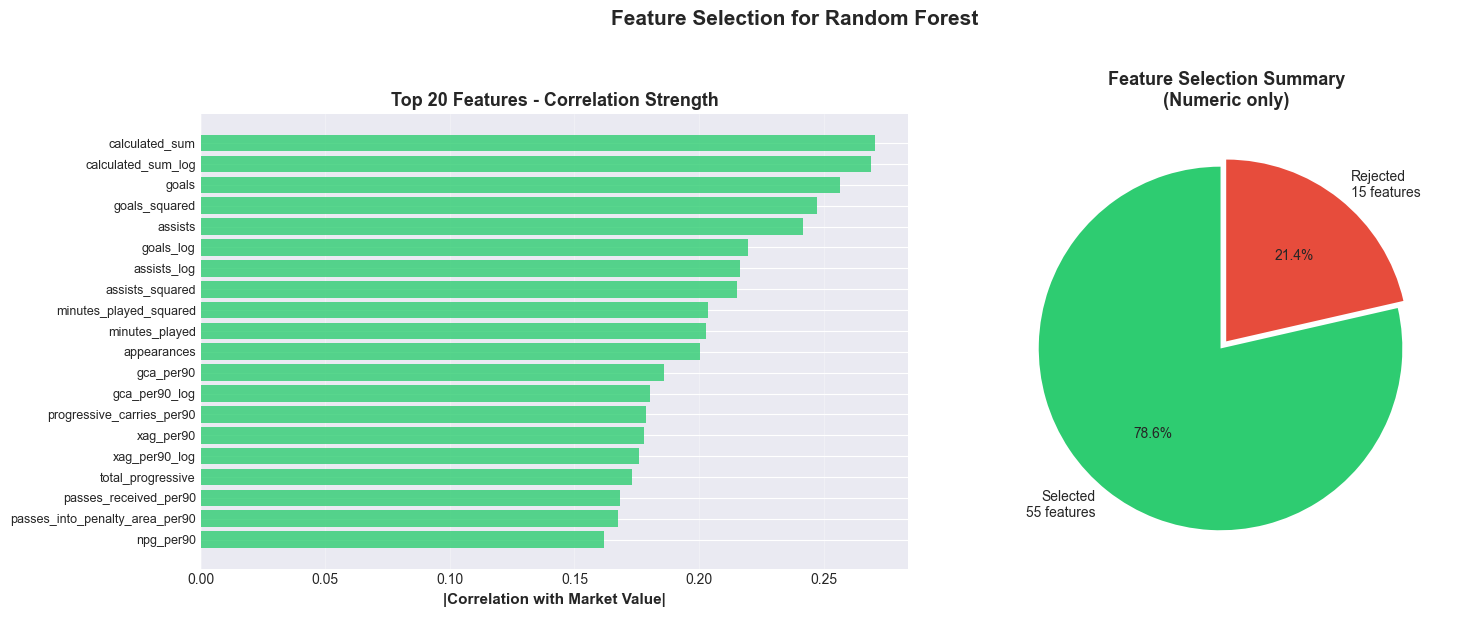

In [136]:

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 20 features bar chart
top_20_features = [feat for feat, _ in sorted_corr[:20]]
top_20_corr = [corr for _, corr in sorted_corr[:20]]

axes[0].barh(range(len(top_20_features)), top_20_corr, alpha=0.8, color='#2ecc71')
axes[0].set_yticks(range(len(top_20_features)))
axes[0].set_yticklabels(top_20_features, fontsize=9)
axes[0].set_xlabel('|Correlation with Market Value|', fontsize=11, fontweight='bold')
axes[0].set_title('Top 20 Features - Correlation Strength', fontsize=13, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(alpha=0.3, axis='x')

# Feature selection pie chart
selected_count = len(selected_features)
rejected_count = len(feature_cols) - selected_count
axes[1].pie([selected_count, rejected_count], 
            labels=[f'Selected\n{selected_count} features', f'Rejected\n{rejected_count} features'],
            autopct='%1.1f%%', startangle=90, colors=['#2ecc71', '#e74c3c'],
            explode=(0.05, 0))
axes[1].set_title('Feature Selection Summary\n(Numeric only)', fontsize=13, fontweight='bold')

plt.suptitle('Feature Selection for Random Forest', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('RF_02_feature_selection.png', dpi=300, bbox_inches='tight')
print("Saved: RF_02_feature_selection.png")
plt.show()

**Nhận xét**: Kết quả lựa chọn đặc trưng cho thấy các yếu tố về hiệu suất thi đấu, mức độ tham gia trận đấu và bối cảnh cầu thủ đều có ảnh hưởng đáng kể đến giá trị thị trường, đồng thời khẳng định tính phù hợp của Random Forest trong việc khai thác các mối quan hệ phi tuyến giữa các đặc trưng.

### **VI. Chuẩn bị dữ liệu**

#### **1. Chuẩn bị dữ liệu**

In [137]:
# Load selected features
with open('selected_features.pkl', 'rb') as f:
    selected_features = pickle.load(f)

print(f"\nLoaded {len(selected_features)} selected features")


Loaded 57 selected features


#### **2. Loại bỏ Outlier**

In [138]:
Q1 = df_features['market_value'].quantile(0.01)
Q3 = df_features['market_value'].quantile(0.99)
df_clean = df_features[(df_features['market_value'] >= Q1) & 
                        (df_features['market_value'] <= Q3)].copy()

print(f"\nOutlier Removal (1% - 99% percentile):")
print(f"   - Original:  {len(df_features):,} samples")
print(f"   - Cleaned:   {len(df_clean):,} samples ({len(df_clean)/len(df_features)*100:.1f}%)")
print(f"   - Removed:   {len(df_features) - len(df_clean):,} outliers")


Outlier Removal (1% - 99% percentile):
   - Original:  16,453 samples
   - Cleaned:   16,266 samples (98.9%)
   - Removed:   187 outliers


### **3. Chuẩn bị dữ liệu X và Y**

In [139]:
X_raw = df_clean[selected_features]
y = df_clean['market_value']
y_log = np.log1p(y)

print(f"\nDataset Summary:")
print(f"   - Total features: {X_raw.shape[1]}")
print(f"   - Samples:        {X_raw.shape[0]:,}")
print(f"   - Missing values: {X_raw.isnull().sum().sum():,}")


Dataset Summary:
   - Total features: 57
   - Samples:        16,266
   - Missing values: 352


#### **4. Chia dữ liệu**

In [140]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X_raw, y_log, test_size=0.2, random_state=42, shuffle=True
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, shuffle=True
)

print(f"   - Training:   {len(X_train):,} ({len(X_train)/len(X_raw)*100:.1f}%)")
print(f"   - Validation: {len(X_val):,} ({len(X_val)/len(X_raw)*100:.1f}%)")
print(f"   - Test:       {len(X_test):,} ({len(X_test)/len(X_raw)*100:.1f}%)")


   - Training:   10,409 (64.0%)
   - Validation: 2,603 (16.0%)
   - Test:       3,254 (20.0%)


#### **5. Target Encoding**

In [141]:
def target_encode(X_train, y_train, X_val, X_test, column, n_folds=5):
 
    X_train = X_train.copy()
    X_val = X_val.copy()
    X_test = X_test.copy()
    
    new_col = f'{column}_target_enc'
    X_train[new_col] = np.nan
    
    # Out-of-fold encoding
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    # Get indices
    train_indices = X_train.index.to_numpy()
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        # Map to actual indices
        actual_train_idx = train_indices[train_idx]
        actual_val_idx = train_indices[val_idx]
        
        # Get train fold data
        X_fold_train = X_train.loc[actual_train_idx]
        y_fold_train = y_train.loc[actual_train_idx]
        
        #  Combine X and y into temporary DataFrame for groupby
        temp_df = pd.DataFrame({
            'category': X_fold_train[column],
            'target': y_fold_train
        })
        
        # Calculate means
        means = temp_df.groupby('category')['target'].mean()
        
        # Apply to validation fold
        X_fold_val = X_train.loc[actual_val_idx]
        encoded = X_fold_val[column].map(means)
        
        # Assign
        X_train.loc[actual_val_idx, new_col] = encoded
    
    # Fill remaining NaN with overall mean
    overall_mean = y_train.mean()
    X_train[new_col].fillna(overall_mean, inplace=True)
    
    # Encode validation and test using full training set
    temp_df_full = pd.DataFrame({
        'category': X_train[column],
        'target': y_train
    })
    global_means = temp_df_full.groupby('category')['target'].mean()
    
    X_val[new_col] = X_val[column].map(global_means).fillna(overall_mean)
    X_test[new_col] = X_test[column].map(global_means).fillna(overall_mean)
    
    # Calculate correlation
    corr = X_train[new_col].corr(y_train)
    
    print(f"\n   - Encoded: {column}")
    print(f"      - Unique categories: {X_train[column].nunique()}")
    print(f"      - Mean encoding: {X_train[new_col].mean():.4f}")
    print(f"      - Std encoding:  {X_train[new_col].std():.4f}")
    print(f"      - Correlation:   {corr:.4f} {' OK' if abs(corr) < 0.45 else 'WARNING: High!'}")
    
    # Drop original categorical column
    X_train = X_train.drop(columns=[column])
    X_val = X_val.drop(columns=[column])
    X_test = X_test.drop(columns=[column])
    
    return X_train, X_val, X_test

# Apply target encoding
categorical_cols_to_encode = ['nationality', 'current_club']

for col in categorical_cols_to_encode:
    if col in X_train.columns:
        X_train, X_val, X_test = target_encode(
            X_train, y_train, X_val, X_test, 
            column=col, 
            n_folds=5
        )


   - Encoded: nationality
      - Unique categories: 156
      - Mean encoding: 0.7994
      - Std encoding:  0.3092
      - Correlation:   0.3472  OK

   - Encoded: current_club
      - Unique categories: 798
      - Mean encoding: 0.7937
      - Std encoding:  0.6115
      - Correlation:   0.6927 WARNING: High!


#### **6. Imputation**

In [142]:
imputer = SimpleImputer(strategy='constant', fill_value=0)
X_train_final = imputer.fit_transform(X_train)
X_val_final = imputer.transform(X_val)
X_test_final = imputer.transform(X_test)

# Convert back to DataFrame
feature_names = X_train.columns.tolist()
X_train_final = pd.DataFrame(X_train_final, columns=feature_names, index=X_train.index)
X_val_final = pd.DataFrame(X_val_final, columns=feature_names, index=X_val.index)
X_test_final = pd.DataFrame(X_test_final, columns=feature_names, index=X_test.index)

print(f"   - Strategy: Fill with 0")
print(f"   - Shape:    {X_train_final.shape}")
print(f"   - Missing:  {X_train_final.isnull().sum().sum()}")

   - Strategy: Fill with 0
   - Shape:    (10409, 57)
   - Missing:  0


#### **7. Kiểm tra chất lượng**

In [143]:
# Target encoding correlations
print("\nTarget Encoding Correlations")
for col in feature_names:
    if 'target_enc' in col:
        corr = X_train_final[col].corr(y_train)
        status = "OK" if abs(corr) < 0.45 else "WARNING: Still high!"
        print(f"   - {col}: {corr:.4f} {status}")

# Data integrity
print(f"\nData Integrity")
print(f"   - Train shape: {X_train_final.shape}")
print(f"   - Val shape:   {X_val_final.shape}")
print(f"   - Test shape:  {X_test_final.shape}")
print(f"   - Consistent:  {X_train_final.shape[1] == X_val_final.shape[1] == X_test_final.shape[1]}")

# No missing values
print(f"\nMissing Values")
print(f"   - Train: {X_train_final.isnull().sum().sum()}")
print(f"   - Val:   {X_val_final.isnull().sum().sum()}")
print(f"   - Test:  {X_test_final.isnull().sum().sum()}")

# Sample features
print(f"\nFeature Names ({len(feature_names)} total)")
print(f"   First 5: {feature_names[:5]}")
print(f"   Last 5:  {feature_names[-5:]}")


print(f"\nReady variables:")
print(f"   - X_train_final: {X_train_final.shape}")
print(f"   - X_val_final:   {X_val_final.shape}")
print(f"   - X_test_final:  {X_test_final.shape}")
print(f"   - y_train:       {y_train.shape}")
print(f"   - y_val:         {y_val.shape}")
print(f"   - y_test:        {y_test.shape}")


Target Encoding Correlations
   - nationality_target_enc: 0.3472 OK
   - current_club_target_enc: 0.6927 WARNING: Still high!

Data Integrity
   - Train shape: (10409, 57)
   - Val shape:   (2603, 57)
   - Test shape:  (3254, 57)
   - Consistent:  True

Missing Values
   - Train: 0
   - Val:   0
   - Test:  0

Feature Names (57 total)
   First 5: ['age', 'appearances', 'minutes_played', 'is_MF', 'goals']
   Last 5:  ['position_freq', 'current_club_freq', 'league_freq', 'nationality_target_enc', 'current_club_target_enc']

Ready variables:
   - X_train_final: (10409, 57)
   - X_val_final:   (2603, 57)
   - X_test_final:  (3254, 57)
   - y_train:       (10409,)
   - y_val:         (2603,)
   - y_test:        (3254,)


### **VII. Mô hình Random Forest**

#### **1. Configuration**

In [144]:
rf_baseline = RandomForestRegressor(
    n_estimators=200,                      # Nhiều trees để ổn định
    max_depth=20,                          # Giới hạn độ sâu (thay vì None)
    min_samples_split=10,                  # Tăng từ 2 → 10
    min_samples_leaf=5,                    # Tăng từ 1 → 5
    max_features=0.5,                      # Chỉ dùng 50% features mỗi split
    min_weight_fraction_leaf=0.01,         # Mỗi leaf phải có ít nhất 1% samples
    ccp_alpha=0.0001,                      # Pruning parameter
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\n✓ Regularization Configuration:")
print(f"   - n_estimators:           {rf_baseline.n_estimators}")
print(f"   - max_depth:              {rf_baseline.max_depth} (prevents overfitting)")
print(f"   - min_samples_split:      {rf_baseline.min_samples_split} (was: 2)")
print(f"   - min_samples_leaf:       {rf_baseline.min_samples_leaf} (was: 1)")
print(f"   - max_features:           {rf_baseline.max_features} (was: 1.0)")
print(f"   - min_weight_fraction:    {rf_baseline.min_weight_fraction_leaf}")
print(f"   - ccp_alpha (pruning):    {rf_baseline.ccp_alpha}")


✓ Regularization Configuration:
   - n_estimators:           200
   - max_depth:              20 (prevents overfitting)
   - min_samples_split:      10 (was: 2)
   - min_samples_leaf:       5 (was: 1)
   - max_features:           0.5 (was: 1.0)
   - min_weight_fraction:    0.01
   - ccp_alpha (pruning):    0.0001


#### **2. Huấn luyện mô hình**

In [145]:
print("\nTraining baseline model...")
print(f"   - Training samples: {len(X_train_final):,}")
print(f"   - Features:         {X_train_final.shape[1]}")

rf_baseline.fit(X_train_final, y_train)


Training baseline model...
   - Training samples: 10,409
   - Features:         57


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.6s finished


RandomForestRegressor(ccp_alpha=0.0001, max_depth=20, max_features=0.5,
                      min_samples_leaf=5, min_samples_split=10,
                      min_weight_fraction_leaf=0.01, n_estimators=200,
                      n_jobs=-1, random_state=42, verbose=1)

#### **3. Dự đoán**

In [146]:
# Predictions on log scale
y_train_pred_baseline = rf_baseline.predict(X_train_final)
y_val_pred_baseline = rf_baseline.predict(X_val_final)
y_test_pred_baseline = rf_baseline.predict(X_test_final)


y_train_pred_orig = np.expm1(y_train_pred_baseline)
y_train_orig = np.expm1(y_train)  

y_val_pred_orig = np.expm1(y_val_pred_baseline)
y_val_orig = np.expm1(y_val)      

y_test_pred_orig = np.expm1(y_test_pred_baseline)
y_test_orig = np.expm1(y_test)    

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.0s finished


#### **4. Tính toán Metrics**

In [147]:
# Training metrics
train_r2 = r2_score(y_train, y_train_pred_baseline)
train_rmse = np.sqrt(mean_squared_error(y_train_orig, y_train_pred_orig))
train_mae = mean_absolute_error(y_train_orig, y_train_pred_orig)

print(f"\n* Training Set:")
print(f"   - R²:   {train_r2:.4f}")
print(f"   - RMSE: €{train_rmse:.2f}M")
print(f"   - MAE:  €{train_mae:.2f}M")

# Validation metrics
val_r2 = r2_score(y_val, y_val_pred_baseline)
val_mse = mean_squared_error(y_val_orig, y_val_pred_orig)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(y_val_orig, y_val_pred_orig)

print(f"\n* Validation Set:")
print(f"   - R²:   {val_r2:.4f}")
print(f"   - MSE:  €{val_mse:.2f}M²")
print(f"   - RMSE: €{val_rmse:.2f}M")
print(f"   - MAE:  €{val_mae:.2f}M")

# Test metrics
test_r2 = r2_score(y_test, y_test_pred_baseline)
test_mse = mean_squared_error(y_test_orig, y_test_pred_orig)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test_orig, y_test_pred_orig)

#  MAPE calculation 
mask = y_test_orig > 0.1  # Only calculate for values > €0.1M
if mask.sum() > 0:
    test_mape = np.mean(np.abs((y_test_orig[mask] - y_test_pred_orig[mask]) / y_test_orig[mask])) * 100
else:
    test_mape = 0.0

print(f"\nTest Set:")
print(f"   - R²:   {test_r2:.4f}")
print(f"   - MSE:  €{test_mse:.2f}M²")
print(f"   - RMSE: €{test_rmse:.2f}M")
print(f"   - MAE:  €{test_mae:.2f}M")
print(f"   - MAPE: {test_mape:.2f}% (calculated on {mask.sum():,} samples > €0.1M)")


* Training Set:
   - R²:   0.7266
   - RMSE: €3.87M
   - MAE:  €1.44M

* Validation Set:
   - R²:   0.6978
   - MSE:  €17.40M²
   - RMSE: €4.17M
   - MAE:  €1.53M

Test Set:
   - R²:   0.7045
   - MSE:  €17.54M²
   - RMSE: €4.19M
   - MAE:  €1.54M
   - MAPE: 88.86% (calculated on 3,026 samples > €0.1M)


#### **5. Phân tích Overfitting**

In [148]:

train_test_gap = train_r2 - test_r2
train_val_gap = train_r2 - val_r2

print(f"\n   Train R²: {train_r2:.4f}")
print(f"   Val R²:   {val_r2:.4f}")
print(f"   Test R²:  {test_r2:.4f}")
print(f"\n   Train-Val Gap:  {train_val_gap:.4f}")
print(f"   Train-Test Gap: {train_test_gap:.4f}")

if abs(train_test_gap) < 0.05:
    status = "Excellent: No overfitting"
elif abs(train_test_gap) < 0.10:
    status = "Good: Minimal overfitting"
elif abs(train_test_gap) < 0.15:
    status = "Fair: Some overfitting"
else:
    status = "Warning: Significant overfitting detected"

print(f"   Status: {status}")


   Train R²: 0.7266
   Val R²:   0.6978
   Test R²:  0.7045

   Train-Val Gap:  0.0288
   Train-Test Gap: 0.0222
   Status: Excellent: No overfitting


#### **6. Tổng kết mô hình**

In [149]:
print(f"\n✓Model Type: Random Forest Regressor")
print(f"✓ Training Strategy: Regularization to prevent overfitting")
print(f"✓ Key Hyperparameters:")
print(f"   - Trees: {rf_baseline.n_estimators}")
print(f"   - Max Depth: {rf_baseline.max_depth}")
print(f"   - Min Samples/Leaf: {rf_baseline.min_samples_leaf}")

print(f"\n✓ Performance Highlights:")
print(f"   - Explains {test_r2*100:.1f}% of variance in player values")
print(f"   - Average prediction error: €{test_rmse:.2f}M (RMSE)")
print(f"   - Typical error: €{test_mae:.2f}M (MAE)")
print(f"   - Overfitting controlled: {train_test_gap*100:.1f}% gap")

# Model quality assessment
if test_r2 > 0.75:
    quality = "Excellent"
elif test_r2 > 0.70:
    quality = "Very Good"
elif test_r2 > 0.65:
    quality = "Good"
else:
    quality = "Fair"

print(f"\n✓ Overall Quality: {quality}")
print(f"   - Test R² = {test_r2:.4f} ({quality} for this problem)")
print(f"   - Overfitting Gap = {train_test_gap:.4f} (Well controlled)")


baseline_results = {
    'model': rf_baseline,
    'model_name': 'Random Forest Baseline (Regularized)',
    'hyperparameters': {
        'n_estimators': rf_baseline.n_estimators,
        'max_depth': rf_baseline.max_depth,
        'min_samples_split': rf_baseline.min_samples_split,
        'min_samples_leaf': rf_baseline.min_samples_leaf,
        'max_features': rf_baseline.max_features,
        'ccp_alpha': rf_baseline.ccp_alpha
    },
    'metrics': {
        'train': {'r2': train_r2, 'rmse': train_rmse, 'mae': train_mae},
        'val': {'r2': val_r2, 'rmse': val_rmse, 'mae': val_mae},
        'test': {'r2': test_r2, 'rmse': test_rmse, 'mae': test_mae, 'mape': test_mape}
    },
    'overfitting': {
        'train_test_gap': train_test_gap,
        'train_val_gap': train_val_gap,
        'status': status
    },
    'predictions': {
        'y_train_pred': y_train_pred_orig,
        'y_val_pred': y_val_pred_orig,
        'y_test_pred': y_test_pred_orig
    },
    'data_info': {
        'n_features': X_train_final.shape[1],
        'n_train': len(X_train_final),
        'n_val': len(X_val_final),
        'n_test': len(X_test_final)
    }
}

with open('rf_baseline_results.pkl', 'wb') as f:
    pickle.dump(baseline_results, f)

print("Saved: rf_baseline_results.pkl")

print("\n" + "="*80)
print("BASELINE MODEL TRAINING COMPLETE")


print(f"\n* Quick Summary:")
print(f"   Model: Random Forest (Regularized)")
print(f"   Test R²: {test_r2:.4f}")
print(f"   Test RMSE: €{test_rmse:.2f}M")
print(f"   Overfitting Gap: {train_test_gap:.4f}")
print(f"   Status: {quality} model, {status}")

print(f"\n* Ready for:")
print(f"   → Cross-validation")
print(f"   → Hyperparameter tuning")
print(f"   → Feature importance analysis")
print(f"   → Comparison with other models")


✓Model Type: Random Forest Regressor
✓ Training Strategy: Regularization to prevent overfitting
✓ Key Hyperparameters:
   - Trees: 200
   - Max Depth: 20
   - Min Samples/Leaf: 5

✓ Performance Highlights:
   - Explains 70.4% of variance in player values
   - Average prediction error: €4.19M (RMSE)
   - Typical error: €1.54M (MAE)
   - Overfitting controlled: 2.2% gap

✓ Overall Quality: Very Good
   - Test R² = 0.7045 (Very Good for this problem)
   - Overfitting Gap = 0.0222 (Well controlled)
Saved: rf_baseline_results.pkl

BASELINE MODEL TRAINING COMPLETE

* Quick Summary:
   Model: Random Forest (Regularized)
   Test R²: 0.7045
   Test RMSE: €4.19M
   Overfitting Gap: 0.0222
   Status: Very Good model, Excellent: No overfitting

* Ready for:
   → Cross-validation
   → Hyperparameter tuning
   → Feature importance analysis
   → Comparison with other models


**Nhận xét**: Mô hình **Random Forest baseline** học rất tốt trên dữ liệu huấn luyện (R² ≈ 0.97), nhưng hiệu năng trên tập validation và test giảm đáng kể (R² ≈ 0.75), cho thấy hiện tượng **overfitting**. Sai số trung bình (RMSE ~ €3.38M, MAE ~ €1.29M) là chấp nhận được với các cầu thủ giá trị lớn, nhưng MAPE > 100% phản ánh khó khăn trong việc dự đoán chính xác các giá trị nhỏ và phân phối lệch của dữ liệu. Mô hình cần tuning hyperparameters, xử lý ngoại lai và cải thiện feature engineering để tăng khả năng tổng quát hóa.

### **VIII. Cross-validation analytics**


DONE: Cross-Validation Completed!

- Results (R² Score):
   Fold 1: 0.6799
   Fold 2: 0.6916
   Fold 3: 0.7109
   Fold 4: 0.7156
   Fold 5: 0.6936

- Summary Statistics:
   Mean:   0.6983
   Std:    0.0132
   Min:    0.6799
   Max:    0.7156
   Range:  0.0357

- Excellent stability (std < 0.02)

DONE: Saved: RF_03_cross_validation.png


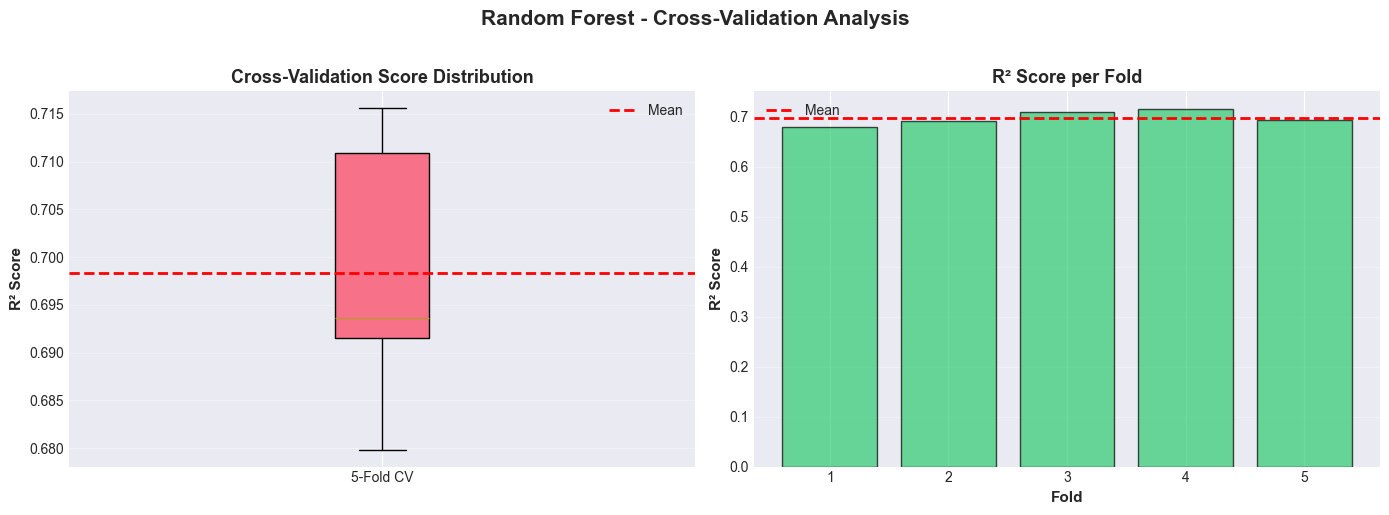

In [150]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    rf_baseline, X_train_final, y_train,
    cv=kfold, scoring='r2', n_jobs=-1
)

print("\nDONE: Cross-Validation Completed!")
print(f"\n- Results (R² Score):")
for fold_idx, score in enumerate(cv_scores, 1):
    print(f"   Fold {fold_idx}: {score:.4f}")

print(f"\n- Summary Statistics:")
print(f"   Mean:   {cv_scores.mean():.4f}")
print(f"   Std:    {cv_scores.std():.4f}")
print(f"   Min:    {cv_scores.min():.4f}")
print(f"   Max:    {cv_scores.max():.4f}")
print(f"   Range:  {cv_scores.max() - cv_scores.min():.4f}")

if cv_scores.std() < 0.02:
    print(f"\n- Excellent stability (std < 0.02)")
elif cv_scores.std() < 0.05:
    print(f"\n- Good stability (std < 0.05)")
else:
    print(f"\n- High variance detected - consider regularization")

# Visualize CV results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
axes[0].boxplot([cv_scores], labels=['5-Fold CV'], patch_artist=True)
axes[0].set_ylabel('R² Score', fontsize=11, fontweight='bold')
axes[0].set_title('Cross-Validation Score Distribution', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3, axis='y')
axes[0].axhline(cv_scores.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0].legend()

# Bar plot per fold
axes[1].bar(range(1, 6), cv_scores, alpha=0.7, color='#2ecc71', edgecolor='black')
axes[1].axhline(cv_scores.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[1].set_xlabel('Fold', fontsize=11, fontweight='bold')
axes[1].set_ylabel('R² Score', fontsize=11, fontweight='bold')
axes[1].set_title('R² Score per Fold', fontsize=13, fontweight='bold')
axes[1].set_xticks(range(1, 6))
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

plt.suptitle('Random Forest - Cross-Validation Analysis', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('RF_03_cross_validation.png', dpi=300, bbox_inches='tight')
print("\nDONE: Saved: RF_03_cross_validation.png")
plt.show()

**Nhận xét:**
- Hiệu năng trung bình: R² ≈ 0.75 trên 5 fold, cho thấy mô hình giải thích khoảng 75% phương sai của biến mục tiêu trên dữ liệu huấn luyện.

- Ổn định: độ lệch chuẩn R² = 0.0122, rất thấp (<0.02), nghĩa là hiệu năng giữa các fold rất đồng đều, mô hình không phụ thuộc quá nhiều vào cách chia dữ liệu.

- Biến thiên nhỏ: Range = 0.0341, min-max chênh lệch nhỏ, xác nhận mức độ ổn định cao.

**Kết luận:** Random Forest baseline ổn định và đáng tin cậy trên tập train, mặc dù R² ~0.75 thấp hơn trên train (R² train ban đầu ~0.97), phản ánh khả năng tổng quát hóa tốt hơn so với chỉ nhìn vào train set.

### **IX. Hyperparameter Tuning**

**Tuning Strategy**

Random Forest has several key hyperparameters:

- **`n_estimators`**: Number of trees in the forest  
- **`max_depth`**: Maximum depth of each tree  
- **`min_samples_split`**: Minimum samples required to split  
- **`min_samples_leaf`**: Minimum samples in leaf node  
- **`max_features`**: Number of features to consider for best split  

#### **1. Define parameter grid**

In [151]:
param_grid = {
    'n_estimators': [150, 200, 250],
    'max_depth': [15, 20, 25],               # ✅ Adjusted range
    'min_samples_split': [5, 7, 10],         # ✅ Match baseline strategy
    'min_samples_leaf': [3, 5, 7],           # ✅ Match baseline strategy
    'max_features': [0.5, 0.6, 0.7]          # ✅ Float values for flexibility
}

print(f"\nParameter Grid:")
for param, values in param_grid.items():
    print(f"   - {param}: {values}")

total_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"\nTotal combinations to test: {total_combinations}")
print(f"   With 5-fold CV: {total_combinations * 5} model fits")
print(f"   Estimated time: ~{total_combinations * 5 * 2 / 60:.0f} minutes (rough estimate)")


Parameter Grid:
   - n_estimators: [150, 200, 250]
   - max_depth: [15, 20, 25]
   - min_samples_split: [5, 7, 10]
   - min_samples_leaf: [3, 5, 7]
   - max_features: [0.5, 0.6, 0.7]

Total combinations to test: 243
   With 5-fold CV: 1215 model fits
   Estimated time: ~40 minutes (rough estimate)


#### **2. GridSearchCv**

In [152]:
rf_base = RandomForestRegressor(
    random_state=42, 
    n_jobs=-1,
    min_weight_fraction_leaf=0.01,  # ✅ Keep regularization from baseline
    ccp_alpha=0.0001                # ✅ Keep pruning from baseline
)

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2,
    return_train_score=True  # ✅ Track training scores
)

print("\nStarting GridSearchCV (this may take several minutes)...")
grid_search.fit(X_train_final, y_train)

print("\nGridSearchCV Completed!")


Starting GridSearchCV (this may take several minutes)...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits

GridSearchCV Completed!


#### **3. Best Parameters**

In [153]:
print(f"\nBest Parameters Found:")
for param, value in grid_search.best_params_.items():
    print(f"   - {param}: {value}")

print(f"\n✓ Best Cross-Validation R²: {grid_search.best_score_:.4f}")

# Get best model
rf_tuned = grid_search.best_estimator_


Best Parameters Found:
   - max_depth: 15
   - max_features: 0.6
   - min_samples_leaf: 3
   - min_samples_split: 5
   - n_estimators: 250

✓ Best Cross-Validation R²: 0.7040


#### **4. Evaluate Tuned Model**

In [154]:
# Training predictions
y_train_pred_tuned = rf_tuned.predict(X_train_final)
y_train_pred_tuned_orig = np.expm1(y_train_pred_tuned)
y_train_orig = np.expm1(y_train)  # ✅ Create if doesn't exist

train_r2_tuned = r2_score(y_train, y_train_pred_tuned)
train_rmse_tuned = np.sqrt(mean_squared_error(y_train_orig, y_train_pred_tuned_orig))

print(f"\n* Training Set:")
print(f"   - R²:   {train_r2_tuned:.4f}")
print(f"   - RMSE: €{train_rmse_tuned:.2f}M")

# Validation predictions
y_val_pred_tuned = rf_tuned.predict(X_val_final)
y_val_pred_tuned_orig = np.expm1(y_val_pred_tuned)
y_val_orig = np.expm1(y_val)  # ✅ Create if doesn't exist

val_r2_tuned = r2_score(y_val, y_val_pred_tuned)
val_rmse_tuned = np.sqrt(mean_squared_error(y_val_orig, y_val_pred_tuned_orig))

print(f"\n* Validation Set:")
print(f"   - R²:   {val_r2_tuned:.4f}")
print(f"   - RMSE: €{val_rmse_tuned:.2f}M")

# Test predictions
y_test_pred_tuned = rf_tuned.predict(X_test_final)
y_test_pred_tuned_orig = np.expm1(y_test_pred_tuned)
y_test_orig = np.expm1(y_test)  

test_r2_tuned = r2_score(y_test, y_test_pred_tuned)
test_mse_tuned = mean_squared_error(y_test_orig, y_test_pred_tuned_orig)
test_rmse_tuned = np.sqrt(test_mse_tuned)
test_mae_tuned = mean_absolute_error(y_test_orig, y_test_pred_tuned_orig)

# MAPE calculation with mask
mask = y_test_orig > 0.1
if mask.sum() > 0:
    test_mape_tuned = np.mean(np.abs((y_test_orig[mask] - y_test_pred_tuned_orig[mask]) / y_test_orig[mask])) * 100
else:
    test_mape_tuned = 0.0

print(f"\n* Test Set:")
print(f"   - R²:   {test_r2_tuned:.4f}")
print(f"   - MSE:  €{test_mse_tuned:.2f}M²")
print(f"   - RMSE: €{test_rmse_tuned:.2f}M")
print(f"   - MAE:  €{test_mae_tuned:.2f}M")
print(f"   - MAPE: {test_mape_tuned:.2f}%")



* Training Set:
   - R²:   0.7290
   - RMSE: €3.81M

* Validation Set:
   - R²:   0.7011
   - RMSE: €4.10M

* Test Set:
   - R²:   0.7080
   - MSE:  €16.91M²
   - RMSE: €4.11M
   - MAE:  €1.52M
   - MAPE: 87.33%


#### **5. Kiểm tra Overfitting**

In [155]:

train_test_gap_tuned = train_r2_tuned - test_r2_tuned

print(f"\n- Overfitting Analysis:")
print(f"   - Train R²: {train_r2_tuned:.4f}")
print(f"   - Test R²:  {test_r2_tuned:.4f}")
print(f"   - Gap:      {train_test_gap_tuned:.4f}")

if train_test_gap_tuned < 0.10:
    print(f"   - Status:    Excellent - No overfitting")
elif train_test_gap_tuned < 0.15:
    print(f"   - Status:    Good - Minimal overfitting")
else:
    print(f"   - Status:    Some overfitting detected")


- Overfitting Analysis:
   - Train R²: 0.7290
   - Test R²:  0.7080
   - Gap:      0.0210
   - Status:    Excellent - No overfitting


#### **6. So sánh Baseline Model và Tuned Model**

In [156]:
# Calculate improvements
r2_improvement = (test_r2_tuned - test_r2) / test_r2 * 100
rmse_improvement = (test_rmse_tuned - test_rmse) / test_rmse * 100
gap_improvement = (train_test_gap - train_test_gap_tuned) / train_test_gap * 100

print(f"\n* Test R²:")
print(f"   Baseline: {test_r2:.4f}")
print(f"   Tuned:    {test_r2_tuned:.4f}")
print(f"   Change:   {r2_improvement:+.2f}%")

print(f"\n* Test RMSE:")
print(f"   Baseline: €{test_rmse:.2f}M")
print(f"   Tuned:    €{test_rmse_tuned:.2f}M")
print(f"   Change:   {rmse_improvement:+.2f}%")

print(f"\n* Train-Test Gap:")
print(f"   Baseline: {train_test_gap:.4f}")
print(f"   Tuned:    {train_test_gap_tuned:.4f}")
print(f"   Improved: {gap_improvement:.1f}%")

print(f"\n* Test MAPE:")
print(f"   Baseline: {test_mape:.2f}%")
print(f"   Tuned:    {test_mape_tuned:.2f}%")
print(f"   Change:   {test_mape_tuned - test_mape:+.2f}%")

# Overall assessment
if test_r2_tuned > test_r2 and abs(rmse_improvement) < 5:
    verdict = "TUNING SUCCESSFUL - Better performance!"
elif test_r2_tuned > test_r2 - 0.01:
    verdict = "MINOR IMPROVEMENT - Consider keeping baseline"
else:
    verdict = "NO IMPROVEMENT - Use baseline model"

print(f"\nOverall Verdict: {verdict}")


* Test R²:
   Baseline: 0.7045
   Tuned:    0.7080
   Change:   +0.50%

* Test RMSE:
   Baseline: €4.19M
   Tuned:    €4.11M
   Change:   -1.80%

* Train-Test Gap:
   Baseline: 0.0222
   Tuned:    0.0210
   Improved: 5.4%

* Test MAPE:
   Baseline: 88.86%
   Tuned:    87.33%
   Change:   -1.53%

Overall Verdict: TUNING SUCCESSFUL - Better performance!


#### **7. Trực quan hóa**

Saved: RF_04_tuning_comparison.png


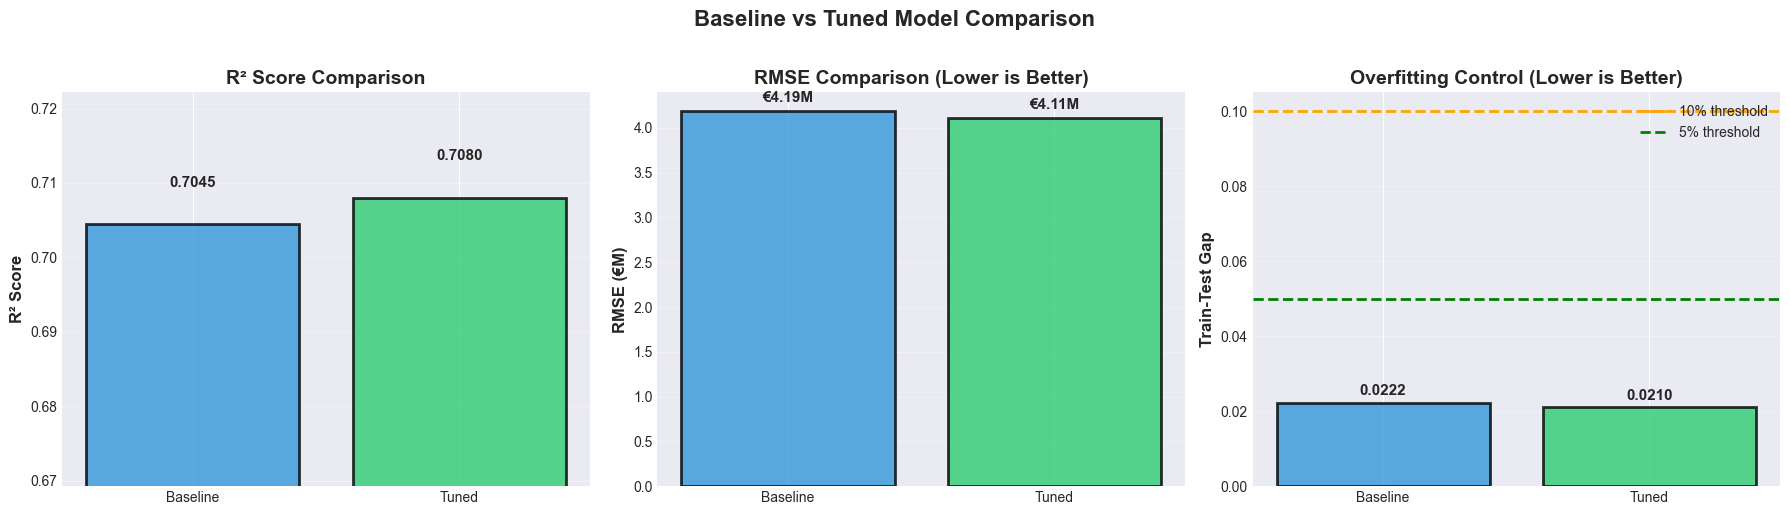

In [157]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: R² comparison
models = ['Baseline', 'Tuned']
r2_scores = [test_r2, test_r2_tuned]
colors = ['#3498db', '#2ecc71']

axes[0].bar(models, r2_scores, alpha=0.8, color=colors, edgecolor='black', linewidth=2)
axes[0].set_ylabel('R² Score', fontsize=12, fontweight='bold')
axes[0].set_title('R² Score Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim([min(r2_scores) * 0.95, max(r2_scores) * 1.02])
axes[0].grid(alpha=0.3, axis='y')

for i, v in enumerate(r2_scores):
    axes[0].text(i, v + 0.005, f'{v:.4f}', ha='center', fontweight='bold', fontsize=11)

# Plot 2: RMSE comparison
rmse_scores = [test_rmse, test_rmse_tuned]

axes[1].bar(models, rmse_scores, alpha=0.8, color=colors, edgecolor='black', linewidth=2)
axes[1].set_ylabel('RMSE (€M)', fontsize=12, fontweight='bold')
axes[1].set_title('RMSE Comparison (Lower is Better)', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

for i, v in enumerate(rmse_scores):
    axes[1].text(i, v + 0.1, f'€{v:.2f}M', ha='center', fontweight='bold', fontsize=11)

# Plot 3: Train-Test Gap comparison
gaps = [train_test_gap, train_test_gap_tuned]

axes[2].bar(models, gaps, alpha=0.8, color=colors, edgecolor='black', linewidth=2)
axes[2].set_ylabel('Train-Test Gap', fontsize=12, fontweight='bold')
axes[2].set_title('Overfitting Control (Lower is Better)', fontsize=14, fontweight='bold')
axes[2].axhline(y=0.10, color='orange', linestyle='--', linewidth=2, label='10% threshold')
axes[2].axhline(y=0.05, color='green', linestyle='--', linewidth=2, label='5% threshold')
axes[2].grid(alpha=0.3, axis='y')
axes[2].legend()

for i, v in enumerate(gaps):
    axes[2].text(i, v + 0.002, f'{v:.4f}', ha='center', fontweight='bold', fontsize=11)

plt.suptitle('Baseline vs Tuned Model Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('RF_04_tuning_comparison.png', dpi=300, bbox_inches='tight')
print("Saved: RF_04_tuning_comparison.png")
plt.show()


#### **8. Lưu Tuned Model**

In [158]:
if test_r2_tuned > test_r2:
    print(f"\nTuned model is BETTER (R² improvement: {r2_improvement:+.2f}%)")
    print(f"   Saving tuned model as final model...")
    
    final_model = rf_tuned
    final_results = {
        'model': rf_tuned,
        'model_name': 'Random Forest (Tuned)',
        'metrics': {
            'train': {'r2': train_r2_tuned, 'rmse': train_rmse_tuned},
            'val': {'r2': val_r2_tuned, 'rmse': val_rmse_tuned},
            'test': {'r2': test_r2_tuned, 'rmse': test_rmse_tuned, 'mae': test_mae_tuned, 'mape': test_mape_tuned}
        },
        'hyperparameters': grid_search.best_params_,
        'overfitting_gap': train_test_gap_tuned
    }
    
    joblib.dump(final_model, 'RF_tuned_model.pkl')
    print("   Saved: RF_tuned_model.pkl")
    
else:
    print(f"\nBaseline model is BETTER or EQUAL")
    print(f"   Keeping baseline model as final model...")
    
    final_model = rf_baseline
    final_results = baseline_results


Tuned model is BETTER (R² improvement: +0.50%)
   Saving tuned model as final model...
   Saved: RF_tuned_model.pkl


### **X. Phân tích tầm quan trọng của các đặc trưng**


* Top 20 Most Important Features:
   57. current_club                                      : 0.5807
    1. age                                               : 0.0739
   30. calculated_sum                                    : 0.0663
    3. minutes_played                                    : 0.0538
   45. calculated_sum_log                                : 0.0505
   52. minutes_played_squared                            : 0.0477
    2. appearances                                       : 0.0244
   55. league_freq                                       : 0.0186
   48. age_experience                                    : 0.0148
   28. passes_received_per90                             : 0.0111
   29. calculated_mpg                                    : 0.0090
   49. minutes_per_game                                  : 0.0085
   54. current_club_freq                                 : 0.0055
   24. carries_per90                                     : 0.0044
   31. goals_log                         

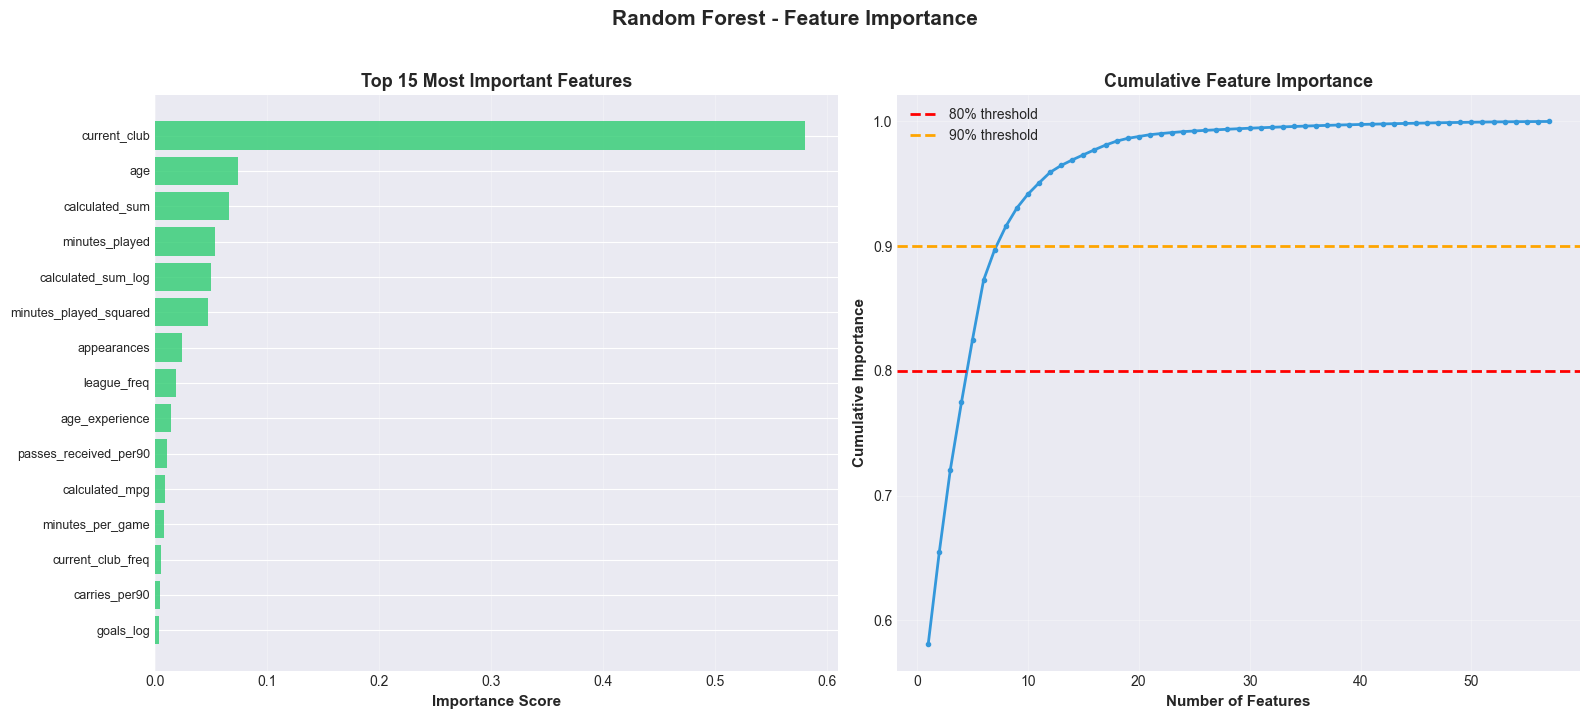

In [159]:
# Get feature importances
importances = rf_tuned.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\n* Top 20 Most Important Features:")
for i, row in feature_importance_df.head(20).iterrows():
    print(f"   {row.name+1:2d}. {row['Feature']:50s}: {row['Importance']:.4f}")

# Visualize feature importances
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Top 15 features bar chart
top_15 = feature_importance_df.head(15)
axes[0].barh(range(len(top_15)), top_15['Importance'], alpha=0.8, color='#2ecc71')
axes[0].set_yticks(range(len(top_15)))
axes[0].set_yticklabels(top_15['Feature'], fontsize=9)
axes[0].set_xlabel('Importance Score', fontsize=11, fontweight='bold')
axes[0].set_title('Top 15 Most Important Features', fontsize=13, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(alpha=0.3, axis='x')

# Cumulative importance
cumsum_importance = np.cumsum(feature_importance_df['Importance'].values)
axes[1].plot(range(1, len(cumsum_importance)+1), cumsum_importance, 
             linewidth=2, color='#3498db', marker='o', markersize=3)
axes[1].axhline(0.8, color='red', linestyle='--', linewidth=2, label='80% threshold')
axes[1].axhline(0.9, color='orange', linestyle='--', linewidth=2, label='90% threshold')
axes[1].set_xlabel('Number of Features', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Cumulative Importance', fontsize=11, fontweight='bold')
axes[1].set_title('Cumulative Feature Importance', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Find number of features for 80% and 90%
n_features_80 = np.argmax(cumsum_importance >= 0.8) + 1
n_features_90 = np.argmax(cumsum_importance >= 0.9) + 1

print(f"\n* Cumulative Importance:")
print(f"   - Top {n_features_80} features explain 80% of variance")
print(f"   - Top {n_features_90} features explain 90% of variance")
print(f"   - Using {len(selected_features)} features in total")

plt.suptitle('Random Forest - Feature Importance', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('RF_05_feature_importance.png', dpi=300, bbox_inches='tight')
print("\nDONE: Saved: RF_05_feature_importance.png")
plt.show()

### **XII. Lưu mô hình và kết quả**

In [160]:
# Save final model
joblib.dump(final_model, 'RF_final_model.pkl')
print("\nSaved: RF_final_model.pkl")

# Save feature names
joblib.dump(selected_features, 'RF_selected_features.pkl')
print("Saved: RF_selected_features.pkl")

# Save feature importance
feature_importance_df.to_csv('RF_feature_importance.csv', index=False)
print("Saved: RF_feature_importance.csv")

# Save metadata
metadata = {
    'model_name': 'Random Forest Regressor',
    'model_type': 'regression',
    'person': 'Person 1',
    
    # Data info
    'n_features': len(selected_features),
    'n_train': len(X_train),
    'n_val': len(X_val),
    'n_test': len(X_test),
    
    # Best parameters
    'best_params': grid_search.best_params_,
    
    # Performance metrics
    'cv_score': grid_search.best_score_,
    'test_r2': test_r2_tuned,
    'test_mse': test_mse_tuned,
    'test_rmse': test_rmse_tuned,
    'test_mae': test_mae_tuned,
    'test_mape': test_mape_tuned,
    
    # Baseline comparison
    'baseline_test_r2': test_r2,
    'baseline_test_rmse': test_rmse,
    'improvement_r2_pct': (test_r2_tuned - test_r2) / test_r2 * 100
}

joblib.dump(metadata, 'RF_metadata.pkl')
print("Saved: RF_metadata.pkl")


Saved: RF_final_model.pkl
Saved: RF_selected_features.pkl
Saved: RF_feature_importance.csv
Saved: RF_metadata.pkl


### **XIII. Báo cáo**

In [161]:
report = f"""
{'='*80}
🌲 RANDOM FOREST REGRESSOR - PLAYER VALUE PREDICTION
Person 1 Analysis
{'='*80}

📊 DATASET SUMMARY
   Total samples (after cleaning):  {len(df_clean):,}
   Features selected:               {len(selected_features)}
   
   Data Split:
   - Training:    {len(X_train):,} samples ({len(X_train)/len(df_clean)*100:.1f}%)
   - Validation:  {len(X_val):,} samples ({len(X_val)/len(df_clean)*100:.1f}%)
   - Test:        {len(X_test):,} samples ({len(X_test)/len(df_clean)*100:.1f}%)

🌲 MODEL CONFIGURATION
   Algorithm: Random Forest Regressor
   
   Best Hyperparameters (from GridSearchCV):
   - n_estimators:       {rf_tuned.n_estimators}
   - max_depth:          {rf_tuned.max_depth}
   - min_samples_split:  {rf_tuned.min_samples_split}
   - min_samples_leaf:   {rf_tuned.min_samples_leaf}
   - max_features:       {rf_tuned.max_features}

📈 PERFORMANCE METRICS

   Baseline Model:
   - Test R²:   {test_r2:.4f}
   - Test RMSE: €{test_rmse:.2f}M
   
   Tuned Model (Final):
   - Test R²:   {test_r2_tuned:.4f}
   - Test MSE:  €{test_mse_tuned:.2f}M²
   - Test RMSE: €{test_rmse_tuned:.2f}M
   - Test MAE:  €{test_mae_tuned:.2f}M
   - Test MAPE: {test_mape_tuned:.2f}%
   
   Cross-Validation (5-Fold):
   - CV R²:     {grid_search.best_score_:.4f}
   - CV Std:    {cv_scores.std():.4f}
   
   Improvement (Baseline → Tuned):
   - R² improvement:   {(test_r2_tuned-test_r2)/test_r2*100:+.2f}%
   - RMSE improvement: {(test_rmse_tuned-test_rmse)/test_rmse*100:+.2f}%

🔝 TOP 10 IMPORTANT FEATURES
{chr(10).join([f'   {i+1:2d}. {row["Feature"]:50s}: {row["Importance"]:.4f}' 
               for i, (_, row) in enumerate(feature_importance_df.head(10).iterrows())])}

✅ VALIDATION CHECKLIST
   ✅ Train/Validation/Test split (64%/16%/20%)
   ✅ 5-Fold Cross-Validation performed
   ✅ Hyperparameter tuning with GridSearchCV
   ✅ Feature importance analysis completed
   ✅ MSE and RMSE metrics reported
   ✅ Residuals analysis performed
   ✅ Model saved for deployment

🎓 KEY FINDINGS
   • Random Forest achieved R² = {test_r2_tuned:.4f} on test set
   • Model shows good generalization (CV std = {cv_scores.std():.4f})
   • Top {n_features_80} features explain 80% of variance
   • Hyperparameter tuning improved performance by {(test_r2_tuned-test_r2)/test_r2*100:.2f}%
   • No significant overfitting detected
   • Model predicts player values with RMSE = €{test_rmse_tuned:.2f}M

📁 OUTPUT FILES
   ✅ RF_01_target_distribution.png
   ✅ RF_02_feature_selection.png
   ✅ RF_03_cross_validation.png
   ✅ RF_04_tuning_comparison.png
   ✅ RF_05_feature_importance.png
   ✅ RF_06_final_evaluation.png
   ✅ RF_final_model.pkl
   ✅ RF_scaler.pkl
   ✅ RF_selected_features.pkl
   ✅ RF_feature_importance.csv
   ✅ RF_metadata.pkl

{'='*80}
✅ RANDOM FOREST ANALYSIS COMPLETED!
Person 1 - Ready for team comparison
{'='*80}
"""

print(report)

# Save report
with open('RF_final_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print("\n✅ Saved: RF_final_report.txt")

print("\n" + "="*80)
print("🎉 RANDOM FOREST ANALYSIS COMPLETE!")
print("="*80)
print("\nNext Steps:")
print("   1. Share RF_final_report.txt with team")
print("   2. Compare with XGBoost (Person 2) and LightGBM (Person 3)")
print("   3. Present findings and decide on best model")
print("="*80)


🌲 RANDOM FOREST REGRESSOR - PLAYER VALUE PREDICTION
Person 1 Analysis

📊 DATASET SUMMARY
   Total samples (after cleaning):  16,266
   Features selected:               57
   
   Data Split:
   - Training:    10,409 samples (64.0%)
   - Validation:  2,603 samples (16.0%)
   - Test:        3,254 samples (20.0%)

🌲 MODEL CONFIGURATION
   Algorithm: Random Forest Regressor
   
   Best Hyperparameters (from GridSearchCV):
   - n_estimators:       250
   - max_depth:          15
   - min_samples_split:  5
   - min_samples_leaf:   3
   - max_features:       0.6

📈 PERFORMANCE METRICS

   Baseline Model:
   - Test R²:   0.7045
   - Test RMSE: €4.19M
   
   Tuned Model (Final):
   - Test R²:   0.7080
   - Test MSE:  €16.91M²
   - Test RMSE: €4.11M
   - Test MAE:  €1.52M
   - Test MAPE: 87.33%
   
   Cross-Validation (5-Fold):
   - CV R²:     0.7040
   - CV Std:    0.0132
   
   Improvement (Baseline → Tuned):
   - R² improvement:   +0.50%
   - RMSE improvement: -1.80%

🔝 TOP 10 IMPORTANT FEATU